In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import bayesflow as bf
import tensorflow as tf

from functools import partial
from IPython.display import HTML
from bayesflow.simulation import Prior, Simulator, GenerativeModel

### Simulator

In [7]:
def initialize_agents(
        num_agents: int = 12,
        boundary_size: float = 10.0,
        rng=None
):
    if rng is None:
        rng = np.random.default_rng()

    positions = rng.uniform(size=(num_agents, 2)) * boundary_size
    directions = rng.uniform(size=num_agents) * 2 * np.pi

    return positions, directions


def simulator_fun(
    theta: np.array = None,
    num_agents: int = 12,
    num_timesteps: int = 100,
    boundary_size: float = 10.0,
    rng=None
):
    if rng is None:
        rng = np.random.default_rng()

    if theta is not None:
        radius, speed, eta = theta[0], theta[1], theta[2]
    else:
        radius, speed, eta = 0.1, 1.0, 0.1

    trajectories = np.zeros((num_timesteps + 1, num_agents, 2))
    headings = np.zeros((num_timesteps + 1, num_agents, 1))

    positions, directions = initialize_agents(num_agents, boundary_size, rng)
    trajectories[0] = positions
    headings[0] = directions[:, np.newaxis]

    for t in range(num_timesteps):
        new_directions = np.zeros(num_agents)
        for i in range(num_agents):
            neighbors = []
            for j in range(num_agents):
                if i != j and np.linalg.norm(positions[i] - positions[j]) < radius:
                    neighbors.append(directions[j])
            if neighbors:
                avg_direction = np.arctan2(np.mean(np.sin(neighbors)), np.mean(np.cos(neighbors)))
                new_directions[i] = avg_direction + rng.uniform(-eta * 0.5, eta * 0.5)
            else:
                new_directions[i] = directions[i]

        directions = new_directions
        positions[:, 0] += speed * np.cos(directions)
        positions[:, 1] += speed * np.sin(directions)
        positions = np.mod(positions, boundary_size)

        trajectories[t + 1] = positions
        headings[t + 1] = directions[:, np.newaxis]

    return np.concatenate((trajectories, headings), axis=-1, dtype=np.float32)

Making sure that it works.

In [12]:
test_path = simulator_fun()
test_path[0,0,:]

array([6.8637066, 2.345882 , 2.0218925], dtype=float32)

### Non-hierarchical priors

\begin{align}
    r &\sim \mathrm{Gamma}(2, 2),\\
    v &\sim \mathrm{Gamma}(0.5, 1),\\
    \eta &\sim \mathcal{U}(0, \pi).
\end{align}

In [9]:
def prior_fun(rng=None):
    
    if rng is None:
        rng = np.random.default_rng()
        
    r = rng.gamma(2,2)
    v = rng.gamma(0.5,1)
    eta = rng.uniform(0, np.pi)
    
    return np.array([r, v, eta], dtype=np.float32)

Again, making sure that it works.

In [10]:
test_prior = prior_fun()
test_prior

array([7.5907383, 0.6415941, 1.9887129], dtype=float32)

### Generative Model

In [14]:
param_names = [r'$r$', r'$v$', r'$\eta$']

In [15]:
prior = Prior(prior_fun=prior_fun, param_names=param_names)

In [16]:
simulator = Simulator(simulator_fun=simulator_fun)

In [17]:
model = GenerativeModel(prior=prior, simulator=simulator, simulator_is_batched=False)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 101, 12, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


### Configurator

In [135]:
def configurator(input_dict: dict = None, time_embedding: bool = False):
    output_dict = {}

    theta = input_dict['prior_draws']
    output_dict['parameters'] = theta

    x = input_dict['sim_data']
    
    # Standardizing the data
    x_mean = np.mean(x)
    x_std = np.std(x)
    
    x = (x - x_mean) / x_std

    # add time encoding to the data x
    if time_embedding:
        batch_size, num_timesteps, num_agents, _ = x.shape
        time_encoding = np.linspace(0, 1, num_timesteps)
        time_encoding_batched = np.tile(
            time_encoding[np.newaxis, :, np.newaxis, np.newaxis], 
            (batch_size, 1, num_agents, 1)
        )
        
    x1 = np.swapaxes(x, 2, 1)
    

    output_dict['summary_conditions'] = x1

    return output_dict

In [137]:
# Test a simulation
test_sim = model(10)
test_sim['sim_data']

array([[[[ 5.1664586e+00,  4.7321081e+00,  7.7865326e-01],
         [ 1.8763785e-01,  9.8685608e+00,  5.5674467e+00],
         [ 2.5866737e+00,  4.5779729e+00,  2.2439966e+00],
         ...,
         [ 6.9779692e+00,  9.6230984e+00,  1.5155379e+00],
         [ 3.7025123e+00,  7.4832034e+00,  5.3338614e+00],
         [ 5.7236242e+00,  7.5624390e+00,  3.9515501e-01]],

        [[ 5.1163716e+00,  5.1014791e+00,  1.7055752e+00],
         [ 5.3519809e-01,  3.2660177e-03,  3.6974850e-01],
         [ 2.5697801e+00,  4.9503417e+00,  1.6161335e+00],
         ...,
         [ 7.3478327e+00,  9.6694078e+00,  1.2455917e-01],
         [ 3.7776616e+00,  7.8483014e+00,  1.3677982e+00],
         [ 5.9962926e+00,  7.8165956e+00,  7.5027335e-01]],

        [[ 5.1835260e+00,  5.4681315e+00,  1.3896482e+00],
         [ 3.3725977e-01,  3.1912047e-01,  2.1305997e+00],
         [ 2.5519383e+00,  5.3226657e+00,  1.6186802e+00],
         ...,
         [ 7.4825573e+00,  1.6960617e-02,  1.2009922e+00],
         [

In [138]:
out = configurator(test_sim)
out['summary_conditions']

array([[[[ 0.48518604,  0.3582728 , -0.79689074],
         [ 0.47055107,  0.4661996 , -0.52605253],
         [ 0.49017298,  0.57333213, -0.6183635 ],
         ...,
         [ 1.0661145 , -0.6809178 , -0.55982584],
         [ 1.064255  , -0.5720191 , -0.56044465],
         [ 1.0570439 , -0.46334353, -0.546074  ]],

        [[-0.96958   ,  1.8590975 ,  0.6023511 ],
         [-0.868026  , -1.0234517 , -0.9163689 ],
         [-0.92586184, -0.931162  , -0.40186423],
         ...,
         [-0.37546822,  0.7386716 , -0.5743309 ],
         [-0.37558904,  0.84758615, -0.56510967],
         [-0.371482  ,  0.95642316, -0.57645446]],

        [[-0.2686036 ,  0.31323588, -0.3687307 ],
         [-0.27353975,  0.42203864, -0.5521866 ],
         [-0.27875295,  0.53082836, -0.55144244],
         ...,
         [ 0.30796108, -0.7230837 , -0.56759864],
         [ 0.3056636 , -0.61419326, -0.5592695 ],
         [ 0.30476993, -0.5052824 , -0.56303626]],

        ...,

        [[ 1.0144929 ,  1.7873756 , -0

### Neural approximator

In [114]:
# As advised, use SetTransformer in place of DeepSet
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.GRU(units=128)),
    bf.networks.SetTransformer(input_dim=128, summary_dim=64)
])

In [107]:
inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=3, 
    num_coupling_layers=6,
    coupling_settings={
        'kernel_regularizer': tf.keras.regularizers.l2(1e-4),
        'dropout_prob': 0.10
    }
)

In [115]:
amortizer = bf.amortizers.AmortizedPosterior(summary_net=summary_net, inference_net=inference_net)

In [139]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [140]:
amortizer.summary()

Model: "amortized_posterior_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network_15 (Inv  multiple                  605292    
 ertibleNetwork)                                                 
                                                                 
 hierarchical_network_4 (Hi  multiple                  468736    
 erarchicalNetwork)                                              
                                                                 
Total params: 1074028 (4.10 MB)
Trainable params: 1073992 (4.10 MB)
Non-trainable params: 36 (144.00 Byte)
_________________________________________________________________


Simulate data for training

In [141]:
simulation = model(5000)

In [142]:
history = trainer.train_offline(simulation, epochs=200, batch_size=512, validation_sims=model(200))

Training epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 3.550


Training epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 3.331


Training epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 2.776


Training epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 2.599


Training epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 2.409


Training epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 2.164


Training epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 2.556


Training epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 2.397


Training epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 2.088


Training epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 2.077


Training epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 2.100


Training epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 1.922


Training epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 2.051


Training epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 2.097


Training epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 1.980


Training epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 1.878


Training epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 2.134


Training epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 2.235


Training epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 2.082


Training epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 1.808


Training epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 1.801


Training epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 1.851


Training epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 1.610


Training epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 1.605


Training epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 1.733


Training epoch 26:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 1.529


Training epoch 27:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 1.572


Training epoch 28:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 1.727


Training epoch 29:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 1.538


Training epoch 30:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 1.530


Training epoch 31:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: 1.821


Training epoch 32:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: 1.466


Training epoch 33:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: 1.477


Training epoch 34:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: 1.627


Training epoch 35:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: 1.451


Training epoch 36:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: 1.449


Training epoch 37:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: 1.516


Training epoch 38:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: 1.321


Training epoch 39:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: 1.356


Training epoch 40:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: 1.479


Training epoch 41:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: 1.346


Training epoch 42:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: 1.370


Training epoch 43:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: 1.463


Training epoch 44:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: 1.193


Training epoch 45:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: 1.374


Training epoch 46:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: 1.331


Training epoch 47:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: 1.212


Training epoch 48:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: 1.225


Training epoch 49:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: 1.412


Training epoch 50:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: 1.256


Training epoch 51:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Loss: 1.201


Training epoch 52:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Loss: 1.416


Training epoch 53:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Loss: 1.165


Training epoch 54:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Loss: 1.274


Training epoch 55:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Loss: 1.565


Training epoch 56:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Loss: 1.027


Training epoch 57:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Loss: 1.182


Training epoch 58:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Loss: 1.362


Training epoch 59:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Loss: 1.038


Training epoch 60:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Loss: 1.129


Training epoch 61:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Loss: 1.232


Training epoch 62:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Loss: 1.079


Training epoch 63:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Loss: 1.105


Training epoch 64:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Loss: 1.173


Training epoch 65:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Loss: 1.027


Training epoch 66:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Loss: 1.049


Training epoch 67:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Loss: 1.188


Training epoch 68:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Loss: 0.941


Training epoch 69:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Loss: 1.032


Training epoch 70:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Loss: 1.090


Training epoch 71:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, Loss: 0.956


Training epoch 72:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, Loss: 0.980


Training epoch 73:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, Loss: 1.234


Training epoch 74:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, Loss: 0.922


Training epoch 75:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, Loss: 1.041


Training epoch 76:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, Loss: 1.140


Training epoch 77:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, Loss: 1.100


Training epoch 78:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, Loss: 0.973


Training epoch 79:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, Loss: 1.045


Training epoch 80:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, Loss: 0.939


Training epoch 81:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, Loss: 0.976


Training epoch 82:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, Loss: 1.043


Training epoch 83:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, Loss: 0.898


Training epoch 84:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, Loss: 0.919


Training epoch 85:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, Loss: 1.034


Training epoch 86:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, Loss: 0.826


Training epoch 87:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, Loss: 0.918


Training epoch 88:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, Loss: 0.994


Training epoch 89:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, Loss: 0.834


Training epoch 90:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, Loss: 0.883


Training epoch 91:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, Loss: 0.983


Training epoch 92:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, Loss: 0.808


Training epoch 93:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, Loss: 0.866


Training epoch 94:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, Loss: 0.912


Training epoch 95:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, Loss: 0.811


Training epoch 96:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, Loss: 0.850


Training epoch 97:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, Loss: 0.916


Training epoch 98:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, Loss: 0.741


Training epoch 99:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, Loss: 0.757


Training epoch 100:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, Loss: 0.900


Training epoch 101:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 101, Loss: 0.767


Training epoch 102:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 102, Loss: 0.780


Training epoch 103:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 103, Loss: 0.959


Training epoch 104:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 104, Loss: 0.764


Training epoch 105:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 105, Loss: 1.142


Training epoch 106:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 106, Loss: 1.159


Training epoch 107:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 107, Loss: 0.999


Training epoch 108:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 108, Loss: 0.713


Training epoch 109:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 109, Loss: 0.815


Training epoch 110:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 110, Loss: 0.875


Training epoch 111:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 111, Loss: 0.819


Training epoch 112:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 112, Loss: 1.136


Training epoch 113:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 113, Loss: 0.764


Training epoch 114:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 114, Loss: 0.804


Training epoch 115:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 115, Loss: 0.653


Training epoch 116:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 116, Loss: 1.455


Training epoch 117:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 117, Loss: 0.920


Training epoch 118:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 118, Loss: 0.682


Training epoch 119:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 119, Loss: 0.694


Training epoch 120:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 120, Loss: 0.690


Training epoch 121:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 121, Loss: 0.850


Training epoch 122:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 122, Loss: 0.793


Training epoch 123:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 123, Loss: 0.564


Training epoch 124:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 124, Loss: 0.716


Training epoch 125:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 125, Loss: 0.760


Training epoch 126:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 126, Loss: 0.835


Training epoch 127:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 127, Loss: 0.845


Training epoch 128:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 128, Loss: 0.638


Training epoch 129:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 129, Loss: 0.586


Training epoch 130:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 130, Loss: 0.540


Training epoch 131:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 131, Loss: 0.597


Training epoch 132:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 132, Loss: 0.529


Training epoch 133:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 133, Loss: 0.501


Training epoch 134:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 134, Loss: 0.559


Training epoch 135:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 135, Loss: 0.499


Training epoch 136:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 136, Loss: 0.530


Training epoch 137:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 137, Loss: 0.572


Training epoch 138:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 138, Loss: 0.494


Training epoch 139:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 139, Loss: 0.514


Training epoch 140:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 140, Loss: 0.579


Training epoch 141:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 141, Loss: 0.500


Training epoch 142:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 142, Loss: 0.503


Training epoch 143:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 143, Loss: 0.553


Training epoch 144:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 144, Loss: 0.478


Training epoch 145:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 145, Loss: 0.506


Training epoch 146:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 146, Loss: 0.558


Training epoch 147:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 147, Loss: 0.547


Training epoch 148:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 148, Loss: 0.492


Training epoch 149:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 149, Loss: 0.501


Training epoch 150:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 150, Loss: 0.495


Training epoch 151:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 151, Loss: 0.541


Training epoch 152:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 152, Loss: 0.512


Training epoch 153:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 153, Loss: 0.487


Training epoch 154:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 154, Loss: 0.466


Training epoch 155:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 155, Loss: 0.541


Training epoch 156:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 156, Loss: 0.457


Training epoch 157:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 157, Loss: 0.516


Training epoch 158:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 158, Loss: 0.507


Training epoch 159:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 159, Loss: 0.502


Training epoch 160:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 160, Loss: 0.474


Training epoch 161:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 161, Loss: 0.455


Training epoch 162:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 162, Loss: 0.449


Training epoch 163:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 163, Loss: 0.456


Training epoch 164:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 164, Loss: 0.448


Training epoch 165:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 165, Loss: 0.438


Training epoch 166:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 166, Loss: 0.427


Training epoch 167:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 167, Loss: 0.430


Training epoch 168:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 168, Loss: 0.490


Training epoch 169:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 169, Loss: 0.473


Training epoch 170:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 170, Loss: 0.434


Training epoch 171:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 171, Loss: 0.414


Training epoch 172:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 172, Loss: 0.450


Training epoch 173:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 173, Loss: 0.448


Training epoch 174:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 174, Loss: 0.423


Training epoch 175:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 175, Loss: 0.429


Training epoch 176:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 176, Loss: 0.436


Training epoch 177:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 177, Loss: 0.424


Training epoch 178:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 178, Loss: 0.421


Training epoch 179:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 179, Loss: 0.427


Training epoch 180:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 180, Loss: 0.424


Training epoch 181:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 181, Loss: 0.406


Training epoch 182:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 182, Loss: 0.412


Training epoch 183:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 183, Loss: 0.423


Training epoch 184:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 184, Loss: 0.403


Training epoch 185:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 185, Loss: 0.398


Training epoch 186:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 186, Loss: 0.404


Training epoch 187:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 187, Loss: 0.401


Training epoch 188:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 188, Loss: 0.409


Training epoch 189:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 189, Loss: 0.414


Training epoch 190:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 190, Loss: 0.408


Training epoch 191:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 191, Loss: 0.404


Training epoch 192:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 192, Loss: 0.410


Training epoch 193:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 193, Loss: 0.404


Training epoch 194:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 194, Loss: 0.401


Training epoch 195:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 195, Loss: 0.400


Training epoch 196:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 196, Loss: 0.401


Training epoch 197:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 197, Loss: 0.403


Training epoch 198:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 198, Loss: 0.403


Training epoch 199:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 199, Loss: 0.404


Training epoch 200:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 200, Loss: 0.403


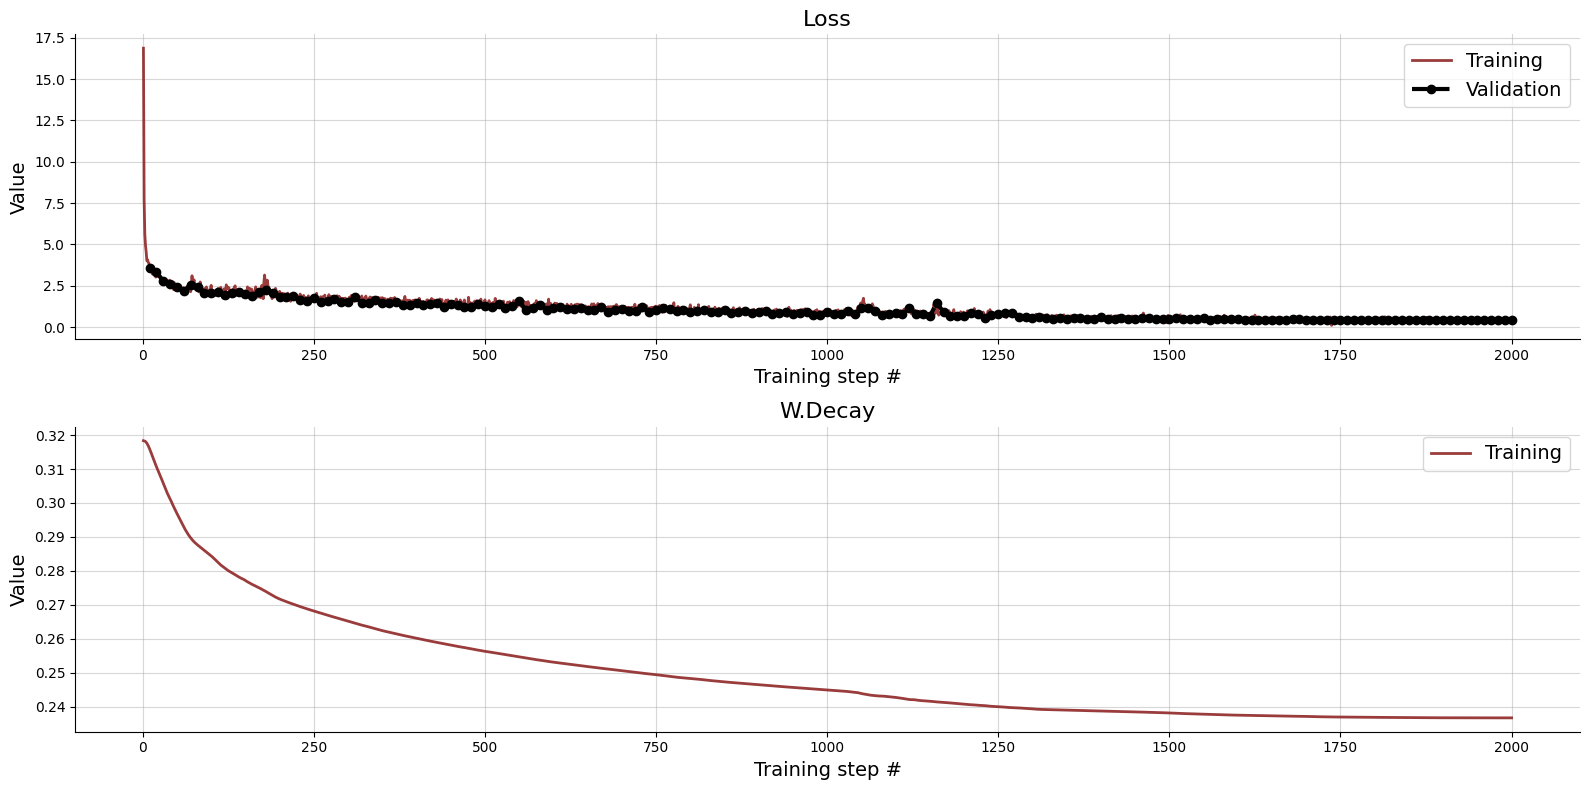

In [143]:
f = bf.diagnostics.plot_losses(history['train_losses'], history['val_losses'])

### Validation

In [144]:
validation_sim = model(200)

In [145]:
validation_sim = configurator(validation_sim)

In [146]:
post_samples = amortizer.sample(validation_sim, n_samples=1000)
post_samples.shape

(200, 1000, 3)

In [147]:
prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=10000)
prior_stds

array([[2.81837   , 0.70119566, 0.90377086]], dtype=float32)

In [148]:
prior_samples = validation_sim["parameters"] * prior_stds + prior_means

Parameter Recovery

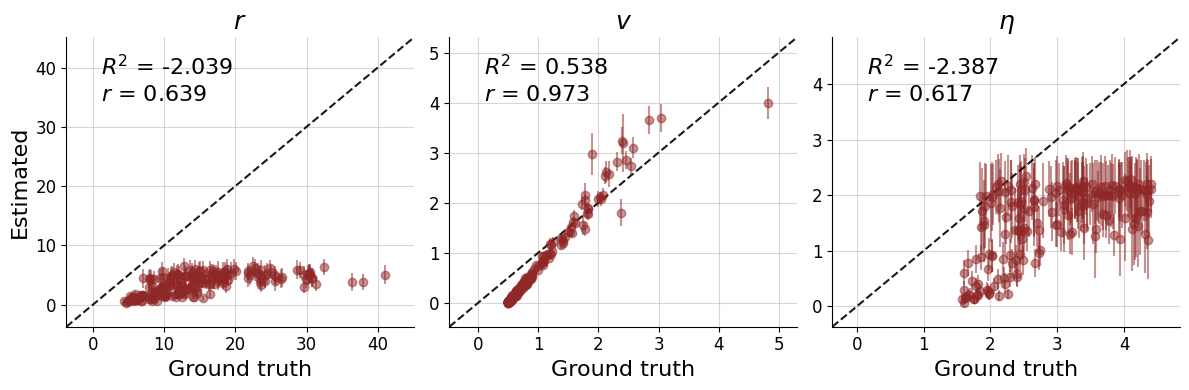

In [149]:
g = bf.diagnostics.plot_recovery(post_samples, prior_samples=prior_samples, param_names=param_names)

Simulation-based calibration

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


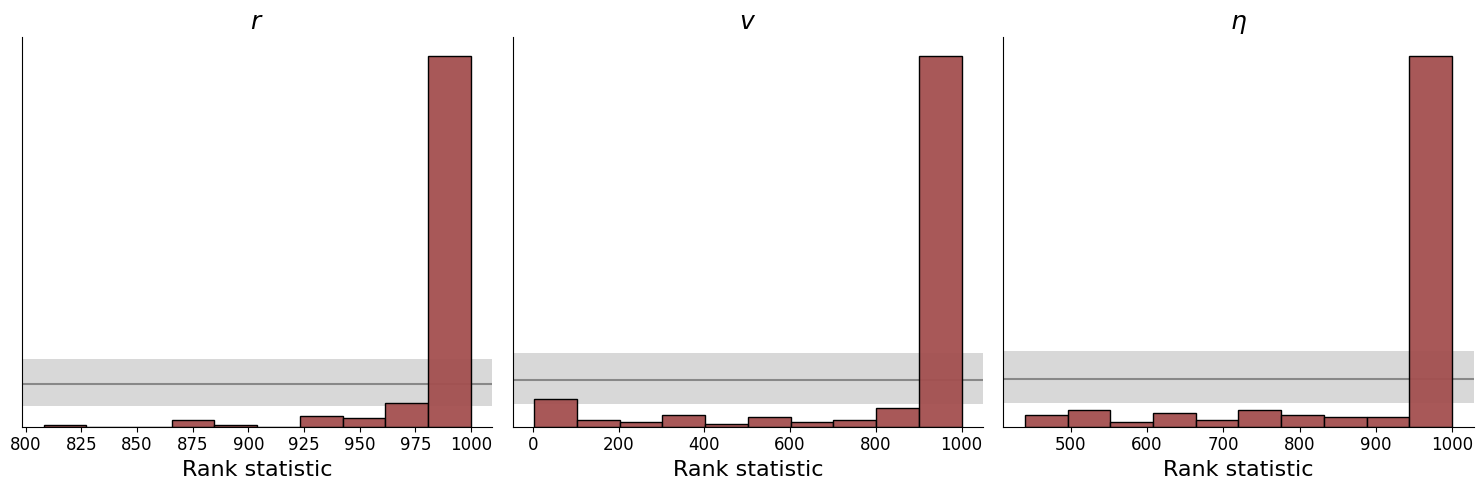

In [150]:
h = bf.diagnostics.plot_sbc_histograms(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names, num_bins=10)

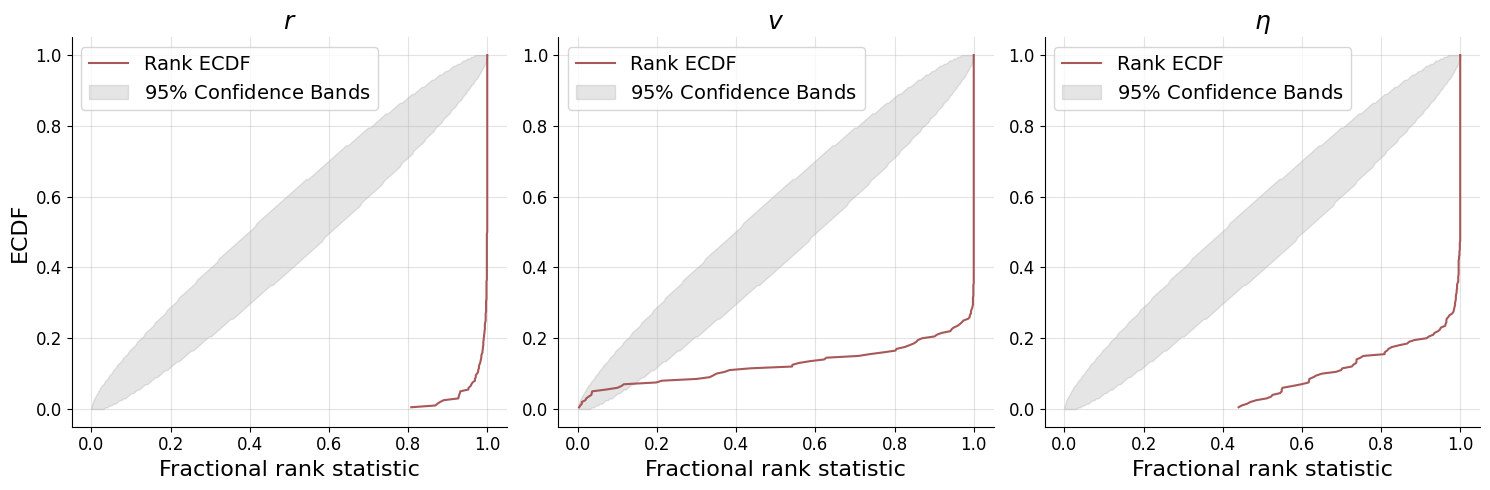

In [151]:
e = bf.diagnostics.plot_sbc_ecdf(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

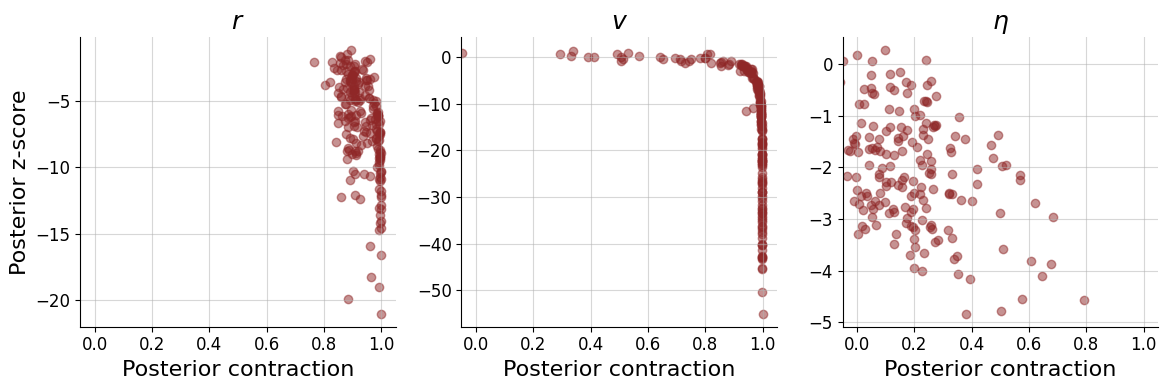

In [133]:
c = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

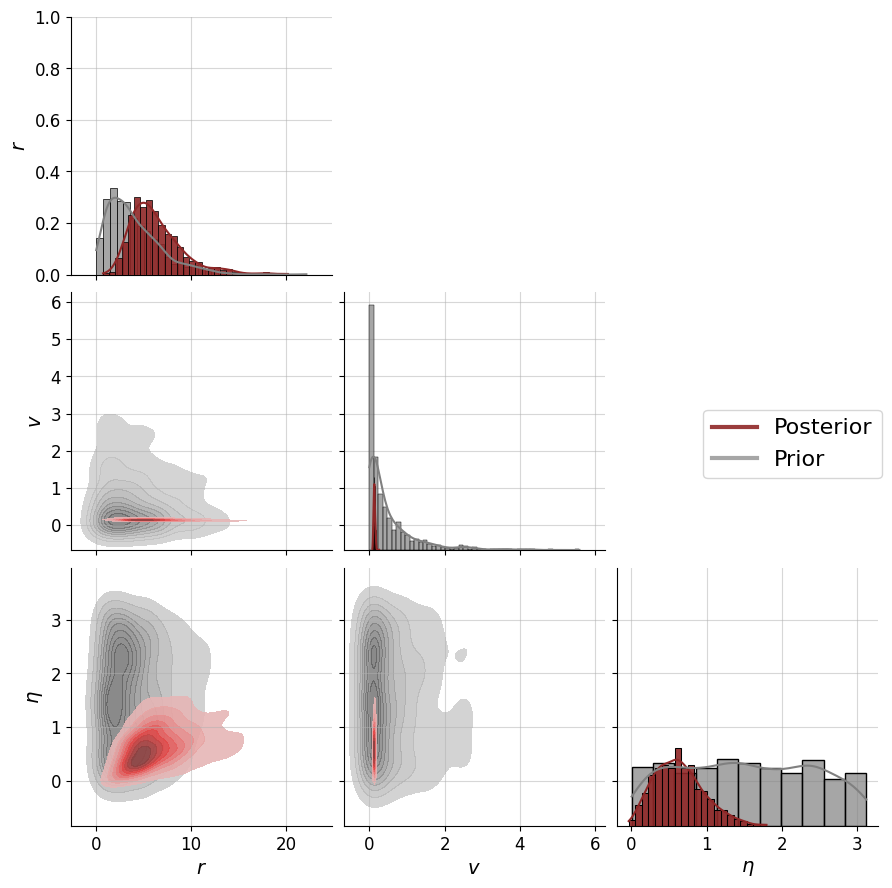

In [152]:
d = bf.diagnostics.plot_posterior_2d(posterior_draws=post_samples[0], prior=prior, param_names=param_names)